In [1]:
# Install necessary libraries (Most are pre-installed in Kaggle)
!pip install -q tensorflow keras opencv-python

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dense , Conv2D , GlobalAveragePooling2D , MaxPooling2D
from tensorflow.keras import Sequential

In [3]:
import matplotlib.pyplot as plt
import cv2
import random
import os

In [4]:

# Dataset path
DATASET_PATH = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone"

Cyst


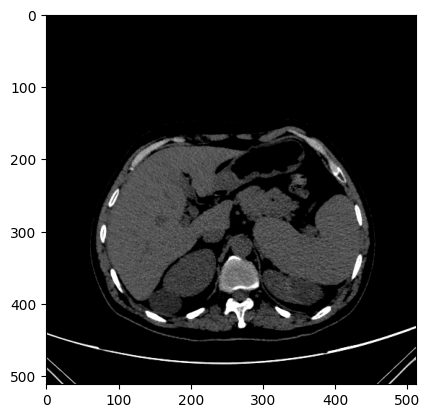

Tumor


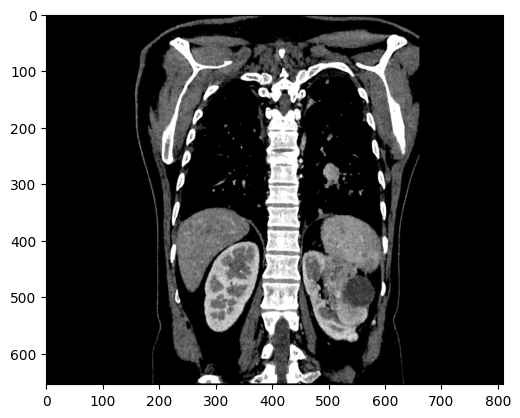

Stone


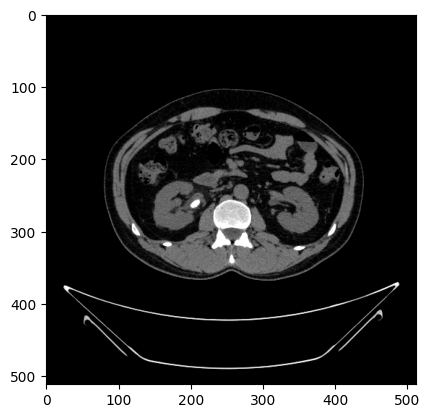

Normal


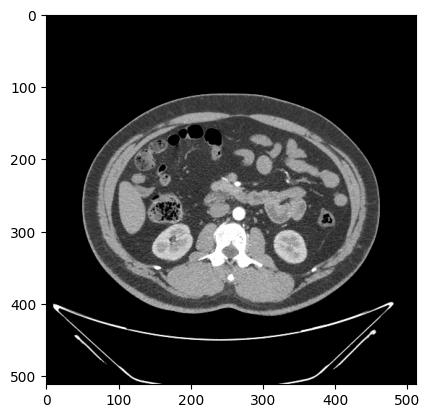

In [5]:
def visualize(x):
  list = os.listdir(x)
  for i in list:
    list1 = os.listdir(x + "/" + i)
    img = random.choice(list1)
    img1 = cv2.imread(x + "/" + i + "/" + img)
    print(i)
    plt.imshow(img1)
    plt.show()

visualize(DATASET_PATH)

In [6]:
# Image dimensions
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30



In [7]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)



In [8]:
trr = image_dataset_from_directory(
    directory = DATASET_PATH,
    label_mode = 'categorical',
    batch_size = 32,
    image_size = (256 ,  256)

)

classnames = trr.class_names


Found 12446 files belonging to 4 classes.


In [9]:
train = ImageDataGenerator(rescale = 1 / 255.)
test = ImageDataGenerator(rescale = 1 / 255.)
val = ImageDataGenerator(rescale = 1 / 255.)

In [10]:
train_data = train.flow_from_directory(
    directory = DATASET_PATH,
    batch_size = 32,
    target_size = (256, 256),
    class_mode = 'categorical'
)

test_data = train.flow_from_directory(
    directory = DATASET_PATH,
    batch_size = 32,
    target_size = (256, 256),
    class_mode = 'categorical'
)

val_data = train.flow_from_directory(
    directory = DATASET_PATH,
    batch_size = 32,
    target_size = (256, 256),
    class_mode = 'categorical'
)

Found 12446 images belonging to 4 classes.
Found 12446 images belonging to 4 classes.
Found 12446 images belonging to 4 classes.


In [11]:
# Let's make some checkpoints
import datetime

# Early Stopping

def early():
  return tf.keras.callbacks.EarlyStopping(patience = 10 , monitor = 'val_loss' , min_delta =0.001 , restore_best_weights = True)


# Model Checkpoint

def point(path):
  return tf.keras.callbacks.ModelCheckpoint(
        path + ".weights.h5" , 
        monitor = 'val_loss' , 
        save_best_only= True , 
        save_weights_only=True , 
        save_freq = "epoch"
  )

# TensorBoard

def board(dir , name):
  folder = dir + "/" + name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  return tf.keras.callbacks.TensorBoard(log_dir = folder)




In [12]:
base = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
base.trainable = False

In [14]:
model2 = Sequential()
model2.add(base)
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256 , activation = 'relu'))
model2.add(Dense(128 , activation = 'relu'))
model2.add(Dense(64 , activation = 'relu'))
model2.add(Dense(32 , activation = 'relu'))
model2.add(Dense(4 , activation = 'softmax'))

model2.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, None, None, 2048)    │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,429,388 (81.75 MB)

 Trainable params: 567,908 (2.17 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [15]:
model2.compile(loss = "categorical_crossentropy" , optimizer ="Adam" , metrics = ['accuracy'])

In [16]:
history2 = model2.fit(train_data ,
                      epochs = 50 ,
                      validation_data = test_data ,
          callbacks = [board("TB" , "transfer") ,
                       early() ,
                       point("transfer.ckpt")]
                      )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


389/389 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7533 - loss: 0.6379

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


389/389 ━━━━━━━━━━━━━━━━━━━━ 200s 461ms/step - accuracy: 0.7535 - loss: 0.6373 - val_accuracy: 0.9786 - val_loss: 0.0755
Epoch 2/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 120s 305ms/step - accuracy: 0.9672 - loss: 0.0967 - val_accuracy: 0.9800 - val_loss: 0.0620
Epoch 3/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 119s 304ms/step - accuracy: 0.9837 - loss: 0.0494 - val_accuracy: 0.9587 - val_loss: 0.1151
Epoch 4/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 120s 305ms/step - accuracy: 0.9856 - loss: 0.0389 - val_accuracy: 0.9550 - val_loss: 0.1596
Epoch 5/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 120s 307ms/step - accuracy: 0.9890 - loss: 0.0343 - val_accuracy: 0.9975 - val_loss: 0.0081
Epoch 6/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 121s 308ms/step - accuracy: 0.9917 - loss: 0.0259 - val_accuracy: 0.9998 - val_loss: 0.0019
Epoch 7/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 120s 305ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9594 - val_loss: 0.1160
Epoch 8/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 120s 306ms/step - accuracy: 0.9910 - loss: 0.02

In [18]:
model2.evaluate(test_data)

389/389 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - accuracy: 1.0000 - loss: 2.1042e-04


[0.0002073481446132064, 1.0]

In [19]:
base.trainable = True
for i in base.layers[:-10]:
  i.trainable = False
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, None, None, 2048)    │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,565,206 (86.08 MB)

 Trainable params: 6,064,228 (23.13 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

 Optimizer params: 1,135,818 (4.33 MB)

In [20]:
model2.compile(loss = "categorical_crossentropy" , optimizer ="Adam" , metrics = ['accuracy'])

In [21]:
history2 = model2.fit(train_data ,
                      epochs = 50 , 
                      validation_data = test_data , 
          callbacks = [board("TB" , "transfer") , early() ,
                       point("transfer.ckpt")]  ,
                      initial_epoch = history2.epoch[-1])

Epoch 20/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 154s 361ms/step - accuracy: 0.8723 - loss: 0.3859 - val_accuracy: 0.9348 - val_loss: 0.2148
Epoch 21/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 128s 327ms/step - accuracy: 0.9827 - loss: 0.0566 - val_accuracy: 0.9540 - val_loss: 0.1501
Epoch 22/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 128s 327ms/step - accuracy: 0.9868 - loss: 0.0393 - val_accuracy: 0.9997 - val_loss: 0.0024
Epoch 23/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 127s 324ms/step - accuracy: 0.9922 - loss: 0.0235 - val_accuracy: 0.9968 - val_loss: 0.0080
Epoch 24/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 127s 324ms/step - accuracy: 0.9980 - loss: 0.0075 - val_accuracy: 0.9378 - val_loss: 0.1616
Epoch 25/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 127s 325ms/step - accuracy: 0.9853 - loss: 0.0582 - val_accuracy: 0.9964 - val_loss: 0.0114
Epoch 26/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 128s 326ms/step - accuracy: 0.9961 - loss: 0.0109 - val_accuracy: 0.9730 - val_loss: 0.0812
Epoch 27/50
389/389 ━━━━━━━━━━━━━━━━━━━━ 147s 375ms/step - accuracy: 

In [25]:
model2.load_weights('/kaggle/working/transfer.ckpt.weights.h5')

In [26]:
model2.evaluate(test_data)

389/389 ━━━━━━━━━━━━━━━━━━━━ 61s 156ms/step - accuracy: 1.0000 - loss: 1.8490e-06


[1.9732738110178616e-06, 1.0]

In [28]:
test_loss, test_acc = model2.evaluate(train_data)


389/389 ━━━━━━━━━━━━━━━━━━━━ 61s 156ms/step - accuracy: 1.0000 - loss: 1.8480e-06
Test Accuracy: 1.0


In [29]:
print(f"Test Accuracy: {test_acc}\ntest loss : {test_loss}")

Test Accuracy: 1.0
test loss : 1.9732731288968353e-06


In [34]:
import numpy as np

# Get a batch of test data
test_images, test_labels = next(iter(test_data))  # Extract one batch

# Predict on the first 10 images
preds = model2.predict(test_images[:50])

# Get the predicted and actual class labels
predicted_classes = np.argmax(preds, axis=1)
actual_classes = np.argmax(test_labels[:50], axis=1)  # Assuming one-hot encoding

# Print results
for i in range(10):
    print(f"Image {i+1}: Predicted Class = {predicted_classes[i]}, Actual Class = {actual_classes[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Image 1: Predicted Class = 1, Actual Class = 1
Image 2: Predicted Class = 2, Actual Class = 2
Image 3: Predicted Class = 1, Actual Class = 1
Image 4: Predicted Class = 1, Actual Class = 1
Image 5: Predicted Class = 0, Actual Class = 0
Image 6: Predicted Class = 0, Actual Class = 0
Image 7: Predicted Class = 1, Actual Class = 1
Image 8: Predicted Class = 0, Actual Class = 0
Image 9: Predicted Class = 1, Actual Class = 1
Image 10: Predicted Class = 1, Actual Class = 1


In [35]:
model2.save('BrainTumorClassificationModel.h5')

In [36]:
model2.save("mymodel.keras")